# Выявление закономерностей, определяющих успешность компьютерных игр, для планирования рекламных кампаний на следующий год


## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

## Изучение данных

In [2]:
games = pd.read_csv('/datasets/games.csv')
#games.head(15)
#games.info()

>1. Датасет содержит 16715 строк и 11 столбцов. Объемно
>2. Приведем названия к нижнему регистру, чтобы а)не путаться в дальнейшем б)для корректного поиска дубликатов.
>3. Проверим данные на дубликаты.
>4. Поищем странные и выбивающиеся значения
>5. Обработаем пропуски в столбцах. Сейчас явно видно, что пропущено огромное количество данных в столбцах с рейтингом и оценками
>6. Изменим тип данных в некоторых столбцах (сейчас явно нуждаются в замене Year_of_Release, Critic_Score, User_Score) 
>7. Удобно было бы также привести рейтинги к одному ранжированию. Например, от 0 до 10.  

## Подготовка даных

### Приведение названий к нижнему регистру

In [3]:
games.columns = games.columns.str.lower() #приводим названия столбцов к нижнему регистру
for names in games[['name', 'platform', 'genre', 'rating']]: #приводим все текстовые данные в датафрейме к нижнему регистру
    games[names] = games[names].str.lower()
    
games.head(15)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006.0,sports,41.36,28.96,3.77,8.45,76.0,8,e
1,super mario bros.,nes,1985.0,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,mario kart wii,wii,2008.0,racing,15.68,12.76,3.79,3.29,82.0,8.3,e
3,wii sports resort,wii,2009.0,sports,15.61,10.93,3.28,2.95,80.0,8,e
4,pokemon red/pokemon blue,gb,1996.0,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,tetris,gb,1989.0,puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,new super mario bros.,ds,2006.0,platform,11.28,9.14,6.50,2.88,89.0,8.5,e
7,wii play,wii,2006.0,misc,13.96,9.18,2.93,2.84,58.0,6.6,e
8,new super mario bros. wii,wii,2009.0,platform,14.44,6.94,4.70,2.24,87.0,8.4,e
9,duck hunt,nes,1984.0,shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


### Проверка на дубликаты

In [4]:
print('Количество дубликатов в датафрейме games:', games.duplicated().sum())

Количество дубликатов в датафрейме games: 0


### Обработка данных в столбцах (поиск странных значений, обработка пропусков, замена типа данных)

In [5]:
games.isnull().sum() #пропуски мы уже отметили ранее при изучении информации, повторим пропуски еще и таким образом, чтобы было удобнее работать

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

#### Названия игр (name)

В столбце name с названием игр, отсутствует 2 значения. Эти же 2 значения пропущены и в genre. Но есть значения в продажах и названии платформы. Чтобы не потерять их, оставим как есть. Тип данных верный

In [6]:
games[games['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,gen,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,gen,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


#### Платформа игры (platform)

In [7]:
games['platform'].unique()

array(['wii', 'nes', 'gb', 'ds', 'x360', 'ps3', 'ps2', 'snes', 'gba',
       'ps4', '3ds', 'n64', 'ps', 'xb', 'pc', '2600', 'psp', 'xone',
       'wiiu', 'gc', 'gen', 'dc', 'psv', 'sat', 'scd', 'ws', 'ng', 'tg16',
       '3do', 'gg', 'pcfx'], dtype=object)

Повторений нет, пропусков нет, тип данных верный

#### Год релиза (year_of_release)

269 пропущенных значений. Видимо, где-то забыли указать год или данные на сохранились. Это всего 1,6% данных от общего объема, не критично. Оставляем

In [8]:
games['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

Странных значений нет. Поменяем год на целое число

In [9]:
games['year_of_release'] = (
   games['year_of_release'].fillna(0)
   .astype(int)
   .astype(object)
   .where(games['year_of_release'].notnull())
)

#games.head()

#### Жанр (genre)

2 значения пропущено. Оставляем как есть. Тип данных верный.

In [10]:
games['genre'].unique() #ищем странные значения

array(['sports', 'platform', 'racing', 'role-playing', 'puzzle', 'misc',
       'shooter', 'simulation', 'action', 'fighting', 'adventure',
       'strategy', nan], dtype=object)

#### Продажи (..._sales) 

Все 4 столбца с продажами не содержат пропусков. Тип данных верный. Посмотрим min на всякий случай. Вдруг есть отрицательные значения

In [11]:
games.describe()

,na_sales,eu_sales,jp_sales,other_sales,critic_score
count,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,0.263377,0.145060,0.077617,0.047342,68.967679
std,0.813604,0.503339,0.308853,0.186731,13.938165
min,0.000000,0.000000,0.000000,0.000000,13.000000
25%,0.000000,0.000000,0.000000,0.000000,60.000000
50%,0.080000,0.020000,0.000000,0.010000,71.000000
75%,0.240000,0.110000,0.040000,0.030000,79.000000
max,41.360000,28.960000,10.220000,10.570000,98.000000


Везде минимум  - нулевое значение, все в порядке

#### Оценки критиков и пользователей  (critic_score и user_score) 

В critic_score почти 50% данных отсутствуют, в user_score все 60%. Предположим, что критики и юзеры не оценили игру вообще. В задаче нам требуется провести исследование по влиянию отзывов пользователей и критиков на продажи. Поэтому оставим пустые значения и в дальнейшем просто будет учитывать параметры "с оценкой" и "без оценки". Поищем странные значения и поменяем тип данных

##### Critic_score

In [12]:
games['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

Странных значений нет. Приведем данные к той же системе оценки, что и у user_score   

In [13]:
games['critic_score'] = games['critic_score'] / 10
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,7.6,8,e
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,8.2,8.3,e
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,8.0,8,e
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


##### User_score

In [14]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Странное значение tbd. Вероятно To Be Determined / To Be Discussed. Может быть эта оценка просто не определена, может быть подлежит проверке. Так ли иначе tbd можно спокойно заменить Nan  

In [15]:
games['user_score'] = games['user_score'].replace('tbd', np.nan) # заменяем tbd на NaN
games['user_score'].unique() # проверяем удачность замены

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

In [16]:
games['user_score'] = games['user_score'].astype(float) #приводим данные в users_score к типу float
games.info() #проверяем удачность замены

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  object 
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### Рейтинг ESRB (rating) 

Пропущено 40% данных. Поскольку игровым компаниями не обязательно предоставлять игру для присовения рейтинга ESRB, думаю, что скорее всего пропуски означают отсутствие этого рейтинга в приниципе. В исследовании этот рейтинг будет важен единожды - нужно определить влияет ли его наличие на продажи или не влияет. Т.е. по сути дела нам важно 2 исхода - "рейтинг есть", "рейтинга нет". А какой именно будет рейтинг, нам не важно. Хотя в рабочей ситуации лучше было бы уточнить этот момент у коллег, кто собирал данные. Вдруг наличие рейтинга есть у большего числа игр, и эта информация просто не подгрузилась. 

В текущей ситуации оставим ячейки с отсутствием рейтинга и проведем дальнейшую проверку.

In [17]:
games['rating'].unique() #поищем странные значения

array(['e', nan, 'm', 't', 'e10+', 'k-a', 'ao', 'ec', 'rp'], dtype=object)

1. Значение k-a = значению e, посокольку до 1998 года использовалась фомулировка kids-to-adults, которая в 1998 году поменялась на everyone
2. Значение rp - raiting pending, т.е. ожидание рейтинга. Данный логотип используется только на рекламных презентациях и в демо-версиях игр до официальной даты выпуска в продажу. То есть по факту возможно была только демоверсия игры, а полная игра так и не вышла. Но возможно и ситуация, когда рейтинг rp просто не поменяли. Посмотрим на данные с rp рейтингом

In [18]:
display(games.query('rating == "rp"'))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
13672,clockwork empires,pc,NaN,strategy,0.0,0.04,0.0,0.00,5.8,3.8,rp
14270,supreme ruler: cold war,pc,2011,strategy,0.0,0.03,0.0,0.01,6.3,6.8,rp
16180,wrc: fia world rally championship,pc,NaN,racing,0.0,0.01,0.0,0.00,6.5,NaN,rp


Объем продаж очень маленький, но он есть. Прогуглив эти игры, выясняем, что они на самом деле существуют не только в демо-версии и были на самом деле выпущены ранее 2016 года. То есть на момент выгрузки данных, скорее всего рейтинг был уже присвоен, но его не поменяли на актуальный. Будем считать, что rp - это тоже значение того, что рейтинг есть.  
Менять k-a на e считаю не обязательным с целью экономия времени. По условию важно только наличие рейтинга или его отсутствие.  
Тип данных в ячейках верный

### Суммарные продажи во всех регионах

Создадим отдельный столбец, в котором посчитаем суммарные продажи от каждой игры по всем регионам

In [19]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,7.6,8.0,e,82.54
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,8.2,8.3,e,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,8.0,8.0,e,32.77
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


## Исследовательский анализ данных

### Количество игр в разные годы выпуска

In [20]:
games_quantity_in_year = games.groupby('year_of_release').agg({'name': ['count']}).reset_index()
games_quantity_in_year.columns = ['year_of_release', 'games_quantity']
#display(games_quantity_in_year)


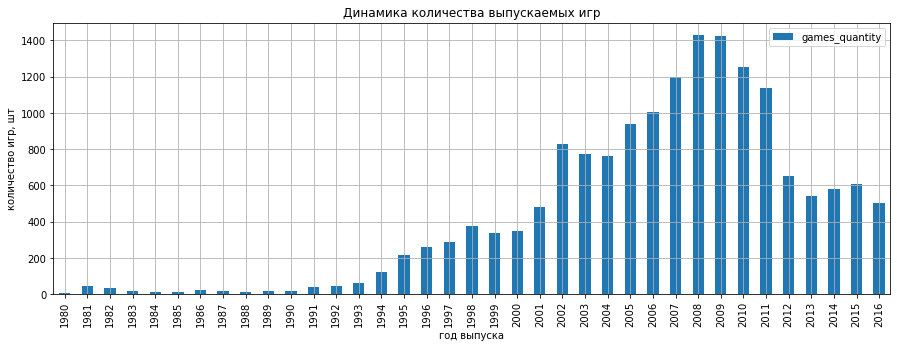

In [21]:
games_quantity_in_year.plot(kind = 'bar', x='year_of_release', figsize = (15,5), grid = True)
plt.title('Динамика количества выпускаемых игр')
plt.xlabel('год выпуска')
plt.ylabel('количество игр, шт')
plt.show()

>* В 1991 году выпускается в 2 раза больше игр, нежели, чем с 1983-1990.Возвращаемся к динамике выпуска в годы 1981 и 1982.  
>* С 1994 года наблюдается стабильный рост релиза компьютерных игр. Есть небольшие спады в 1999-2000 и 2003-2004 годах. Но они совсем незначительны.Рост продолжается вплоть до 2008 года.    
>* В 2008-2009 годах наблюдается пик выпуска игр. Выпущено более 1400 новых игр. Еще 10 лет назад, эта цифра быа менее 400. Рост более чем 250% (!)  
>* С 2009 года все идет на спад.  
>* В 2012-2013 мы видим сильный провал и вплоть до 2016 количество выпущенных игр колеблется примерно на отметке 2012-2013 года (500-600 игр)  
>
>Скорее всего лучше брать данные с 1994 года, когда выпуск игр уже набрал обороты и вплоть до 2016 года, поскольку в задаче мы строим прогноз на 2017 год. Посмотрим далее

### Динамика продаж по платформам. 

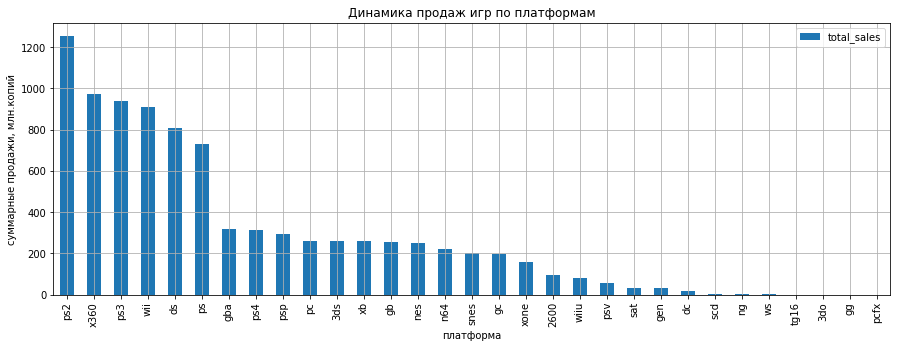

In [22]:
platform_top = games.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending = False)
#print(platform_top)
platform_top.plot(kind= 'bar', figsize = (15,5), grid = True)
plt.title('Динамика продаж игр по платформам')
plt.xlabel('платформа')
plt.ylabel('суммарные продажи, млн.копий')
plt.show()

> У нас есть 6 лидеров: ps2, x360, ps3, wii, ds, ps. 

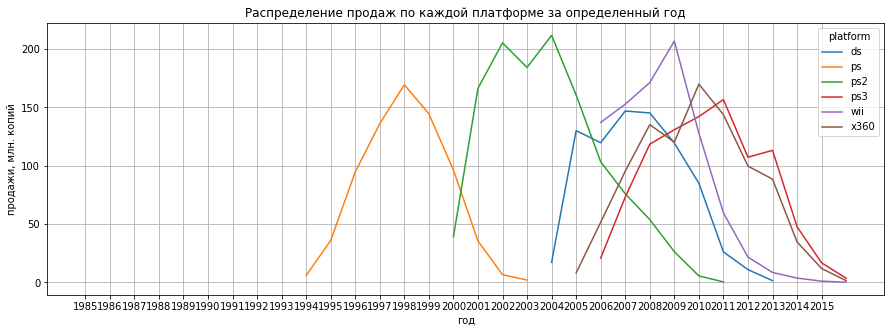

In [23]:
#Построим распределение по годам

platform_top_6 = games.query('platform == ("ps2", "x360", "ps3", "wii", "ds", "ps")') #делаем срез по 6 платформам
platform_top_6_final = platform_top_6.pivot_table(index = ['year_of_release'], columns = 'platform', values = 'total_sales', aggfunc = 'sum') #строим график распределения продаж по каждой платформе за определенный год
platform_top_6_final.plot(figsize = (15,5), grid=True)
plt.title('Распределение продаж по каждой платформе за определенный год')
plt.xlabel('год')
plt.ylabel('продажи, млн. копий')
plt.xticks(np.arange(1985, 2016, 1))
plt.show()




>Первая топовая платформа начала приносить продажи в 1994 году, последняя популярная платформа умерла в 2016.  
>Подтвердилась первая догадка, о том, что нужно брать данные, начиная с  1994 года

#### Расчет среднего срока исчезновения старых платформ (срок жизни платформы)

In [24]:
platform_lifetime = games.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']) #определим год рождения популярных платформ и год, когда они ушли с рынка
platform_lifetime.columns = ['start', 'end'] #переименовываем столбцы
#display(platform_lifetime)


In [25]:
platform_lifetime['lifetime'] = platform_lifetime['end'] - platform_lifetime['start'] #определяем срок жизни каждой платформ
display(platform_lifetime)

,start,end,lifetime
platform,,,
2600,1980,1989,9
3do,1994,1995,1
3ds,2011,2016,5
dc,1998,2008,10
ds,1985,2013,28
gb,1988,2001,13
gba,2000,2007,7
gc,2001,2007,6
gen,1990,1994,4


>У нас явно есть несколько доложителей. Например, pc - 31 год или, неожиданно, ds - 28 лет (1985 год), хотя приносить продажи она начала в 2004. Может быть ошибка, а может быть простой. Так или иначе, учитывать среднее будет не совсем верным. Посчитаем медиану.

In [26]:
print('Старые платформы исчезают в среднем за:', platform_lifetime['lifetime'].median().astype(int), 'лет') #считаем среднее
print('Средняя продолжительность жизни платформы:', platform_lifetime['lifetime'].median().astype(int), 'лет')

Старые платформы исчезают в среднем за: 6 лет
Средняя продолжительность жизни платформы: 6 лет


### Определение актуального периода

Известно, что средняя продолжительность жизни платформы - около 6 лет, а новые платформы появляются в среднем ежегодно. Для определения актуального периода, на мой взгляд, будет полезным еще также посмотреть на отрезок около пика продаж платформы. То есть, за сколько лет в среднем платформа продает на макисмальном уровне.  

Вернемся к нашему графику топ-6 платформ: распределения похожи на нормальные, платформа достигает пика продаж примерно через 3 года после своего появления. 

Для этого возьмем срез по топ-6 платформам, поскольку нам надо понять пик по самым популярным платформам. Этот пик может отличаться от менее популярных.

In [27]:
platform_top_6_final.describe()

platform,ds,ps,ps2,ps3,wii,x360
count,11.000000,10.000000,12.000000,11.000000,11.000000,12.000000
mean,72.980000,72.758000,102.796667,84.667273,81.016364,80.103333
std,61.673155,63.351713,79.405729,54.637565,79.136330,57.484408
min,0.020000,2.070000,0.450000,3.600000,0.180000,1.520000
25%,14.140000,13.900000,35.977500,34.360000,6.170000,29.045000
50%,85.020000,65.330000,89.705000,107.360000,59.650000,91.995000
75%,124.975000,126.220000,170.900000,124.725000,144.960000,124.032500
max,146.940000,169.490000,211.810000,156.780000,206.970000,170.030000


Возьмем даные за третий квартиль. У платформ ds, ps, ps3, х360 это значение примерно одинаковое. 
Отдельно возьмем платформы wii и ps2  
Отметим на нашем готовом графике

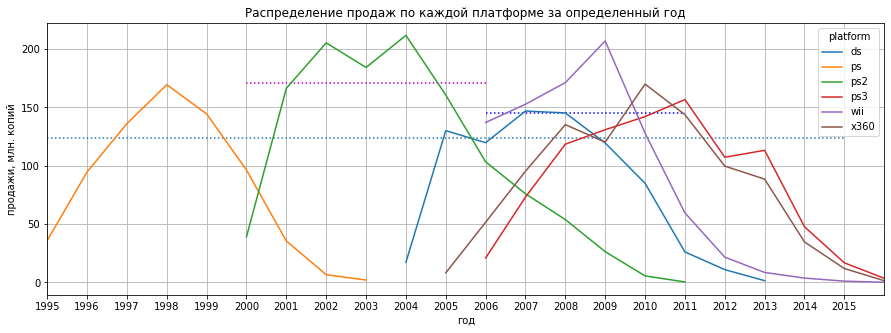

In [28]:
platform_top_6_final.plot(figsize = (15,5), grid=True, xlim=(1995,2016)) #вернемся к графику топовых платформ, уже с актуальным периодом
plt.title('Распределение продаж по каждой платформе за определенный год')
plt.xlabel('год')
plt.ylabel('продажи, млн. копий')
plt.xticks(np.arange(1995, 2016, 1))
plt.hlines(124.0325, 1995, 2015, linestyle = ':')
plt.hlines(170.9, 2000, 2006, color = 'm', linestyle = ':')
plt.hlines(144.96, 2006, 2011,color = 'b', linestyle = ':')
plt.show()

Каждая платформа находится на максимуме продаж примерно 2,5 года, а достигает начала отрезка в среднем через 1,5 года

> Исходя из всего вышеперечисиленного предлагаю взять за **актуальный, период с 2014 по 2016 год**. Скорее всего в 2017 году эти платформы продадут тот максимум, который они могут продать за срок своего существования, а некоторые даже достигнут пика

In [29]:
games_actual = games.query('2014 <= year_of_release <= 2016') #создаем переменную со срезом для актуального времени
games_actual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 31 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1689 non-null   object 
 1   platform         1689 non-null   object 
 2   year_of_release  1689 non-null   object 
 3   genre            1689 non-null   object 
 4   na_sales         1689 non-null   float64
 5   eu_sales         1689 non-null   float64
 6   jp_sales         1689 non-null   float64
 7   other_sales      1689 non-null   float64
 8   critic_score     718 non-null    float64
 9   user_score       888 non-null    float64
 10  rating           940 non-null    object 
 11  total_sales      1689 non-null   float64
dtypes: float64(7), object(5)
memory usage: 171.5+ KB


Получили выборку в 1689 строк

### Выбор потенцально прибыльных платформ в 2017 году

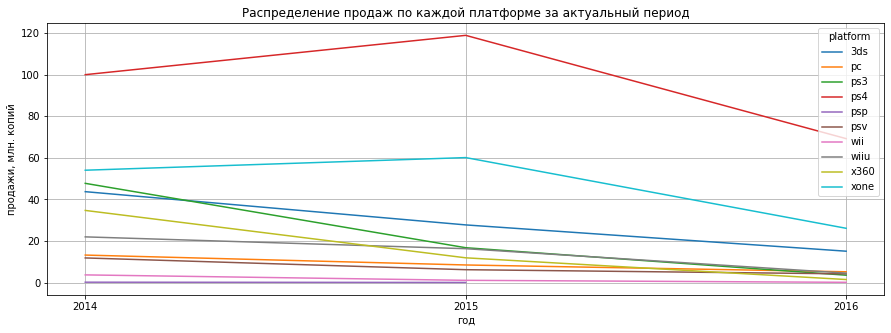

In [30]:
platform_top_2017 = games_actual.pivot_table(index = ['year_of_release'], columns = 'platform',  values = 'total_sales', aggfunc = 'sum')  #строим график распределения продаж по каждой платформе за актуальный период
platform_top_2017.plot(figsize = (15,5), grid=True)
plt.title('Распределение продаж по каждой платформе за актуальный период')
plt.xlabel('год')
plt.ylabel('продажи, млн. копий')
plt.xticks(np.arange(2014, 2017, 1))
plt.show()

>3 лидера:  
>
>1. PS4
>2. Xone
>3. 3ds  
>
>У PS4 есть пик в 2015 году, но скорее всего, это не максимальный пик. Все платформы показывают пока динамику спада, но скорее всего, даже если в 2017 году тенденция сохраниться, эти 3 все равно пока остануться на вершине. А в лучшем случае все же изменят вектор и пойдут вверх, достигая своего максимума

### Диаграмма размаха глобальных продаж игр в разбивке по платформам.

Text(0, 0.5, 'продажи, млн. копий')

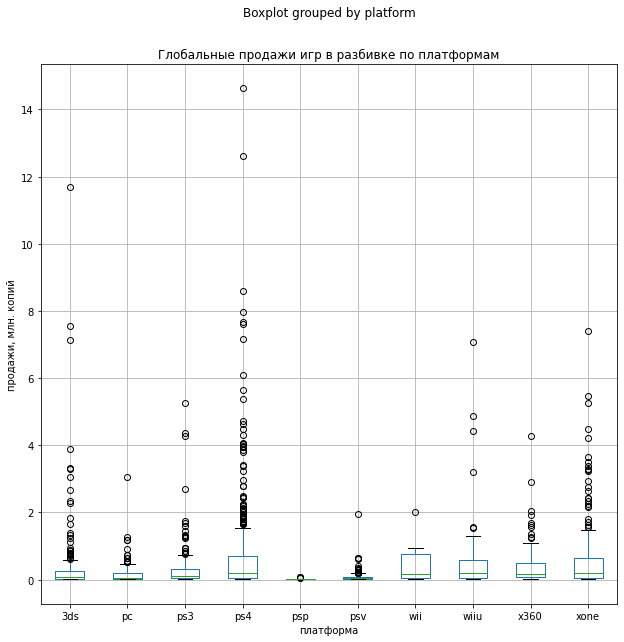

In [31]:
games_actual.boxplot(column='total_sales', by = 'platform', figsize=(10,10))
plt.title('Глобальные продажи игр в разбивке по платформам')
plt.xlabel('платформа')
plt.ylabel('продажи, млн. копий')

Text(0, 0.5, 'продажи, млн. копий')

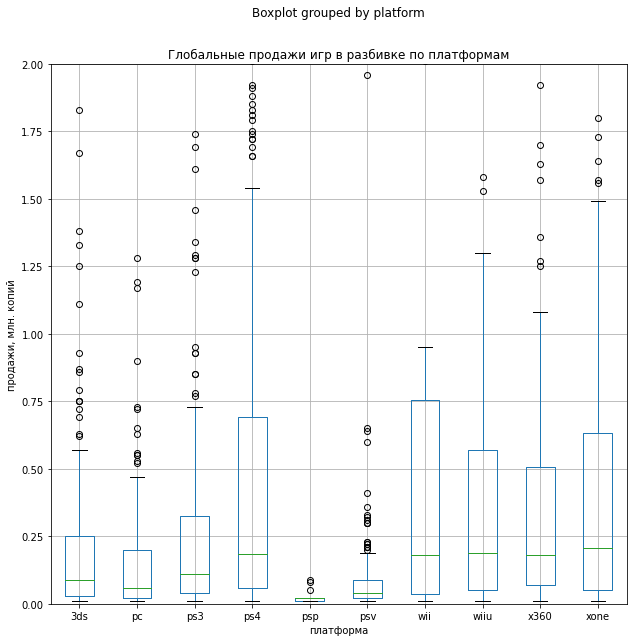

In [32]:
games_actual.boxplot(column='total_sales', by = 'platform', figsize=(10,10))
plt.ylim(0, 2)
plt.title('Глобальные продажи игр в разбивке по платформам')
plt.xlabel('платформа')
plt.ylabel('продажи, млн. копий')


In [33]:
games_actual.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3ds,212.0,0.408868,1.188368,0.01,0.0300,0.090,0.2500,11.68
pc,151.0,0.179139,0.329359,0.01,0.0200,0.060,0.2000,3.05
ps3,219.0,0.311324,0.633059,0.01,0.0400,0.110,0.3250,5.27
ps4,376.0,0.766356,1.614969,0.01,0.0575,0.185,0.6900,14.63
psp,13.0,0.027692,0.027735,0.01,0.0100,0.020,0.0200,0.09
psv,295.0,0.075932,0.141591,0.01,0.0200,0.040,0.0900,1.96
wii,11.0,0.460909,0.625451,0.01,0.0350,0.180,0.7550,2.01
wiiu,73.0,0.588767,1.161467,0.01,0.0500,0.190,0.5700,7.09
x360,111.0,0.434414,0.628967,0.01,0.0700,0.180,0.5050,4.28


> По средним продажам лидирует ps4, и по максимальным она же. На 4 месте находиться платформа wiiu. Интересно, что ее количество игр на 70% ниже количества игр платформы-лидера (3 место) xone, при этом выручка всего на 5% ниже гиганта. Кажется, что ее игры настолько хороши, что в расчете на продажу одной игры, популярны у пользователей в разы больше. Думаю, стоит обратить на нее внимание при дальнейших выводах. Судя по предыдущему графику в 2017 она должна показать примерно одинаковые продажи с xone, возможно чуть меньше.

### Влияние отзывов пользователей и критиков на продажи внутри одной популярной платформы

#### Влияние отзывов критиков на продажи

Для примера возьмем платформу ps4, как самую популярную в актуальном периоде

In [34]:
ps4_score = games_actual.query('platform == "ps4" and critic_score > 0') #делаем срез, включающий оценки критиков
#ps4_score.head(10)
ps4_score_grouped = ps4_score.pivot_table(index = 'critic_score', values = 'total_sales').reset_index()
#ps4_score_grouped.head(15)

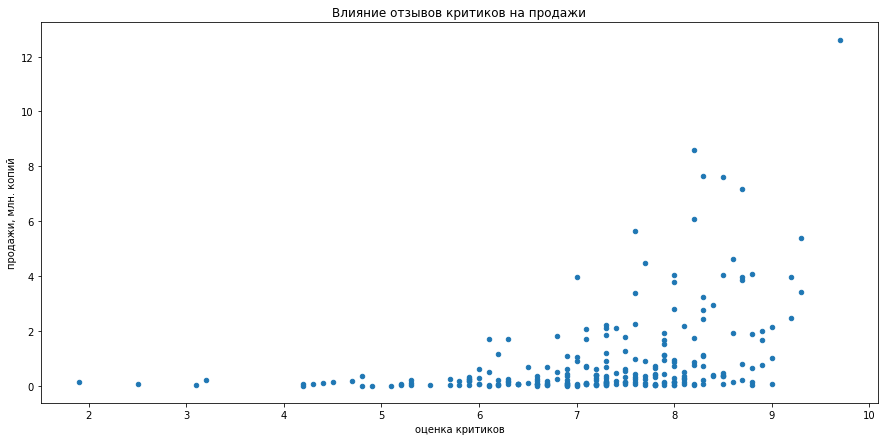

In [35]:
ps4_score.plot(x='critic_score', y='total_sales', kind='scatter', figsize=(15,7))
plt.title('Влияние отзывов критиков на продажи')
plt.xlabel('оценка критиков')
plt.ylabel('продажи, млн. копий')
plt.show()

In [36]:
print('Коэффициент корреляции между оценками критиков и продажами:', ps4_score['critic_score'].corr(ps4_score['total_sales']))

Коэффициент корреляции между оценками критиков и продажами: 0.4026614106810408


> Зависимость есть, но она не очень большая. То есть далеко не всегда высокие оценки критиков обеспечивают высокие продажи.

Посмотрим на коэффициент корреляции у других платформ из актуального периода

In [37]:
score_3ds = games_actual.query('platform == "3ds" and critic_score > 0')
print('3ds:', score_3ds['critic_score'].corr(score_3ds['total_sales']))
score_pc = games_actual.query('platform == "pc" and critic_score > 0')
print('pc:', score_pc['critic_score'].corr(score_pc['total_sales']))
score_ps3 = games_actual.query('platform == "ps3" and critic_score > 0')
print('ps3:', score_ps3['critic_score'].corr(score_ps3['total_sales']))
score_psp = games_actual.query('platform == "psp" and critic_score > 0')
print('psp:', score_psp['critic_score'].corr(score_psp['total_sales']))
score_psv = games_actual.query('platform == "psv" and critic_score > 0')
print('psv:', score_psv['critic_score'].corr(score_psv['total_sales']))
score_wii = games_actual.query('platform == "wii" and critic_score > 0')
print('wii:', score_wii['critic_score'].corr(score_wii['total_sales']))
score_wiiu = games_actual.query('platform == "wiiu" and critic_score > 0')
print('wiiu:', score_wiiu['critic_score'].corr(score_wiiu['total_sales']))
score_x360 = games_actual.query('platform == "x360" and critic_score > 0')
print('x360:', score_x360['critic_score'].corr(score_x360['total_sales']))
score_xone = games_actual.query('platform == "xone" and critic_score > 0')
print('xone:', score_xone['critic_score'].corr(score_xone['total_sales']))

3ds: 0.3141174928690511
pc: 0.1746341376935004
ps3: 0.44657460493190715
psp: nan
psv: 0.042664906570095265
wii: nan
wiiu: 0.37020141248088395
x360: 0.5257228356581523
xone: 0.4286769437033321


> Продажи игр на других платформах также не всегда зависят от отзывов критиков. Зависмость есть, но не сильная. На наличие зависимости я бы обратила внимание только если у x360. У psp и wii, если в моих вычислениях нет ошибки вообще оценки критиков отстутсвуют вплоть с 2014 года

#### Влияние отзывов пользователей на продажи

Платформу оставляем ту же, ps4

In [38]:
ps4_user_score = games_actual.query('platform == "ps4" and user_score > 0') #делаем срез, включающий оценки критиков
ps4_user_score_grouped = ps4_user_score.pivot_table(index = 'user_score', values = 'total_sales')
#ps4_user_score_grouped.head()

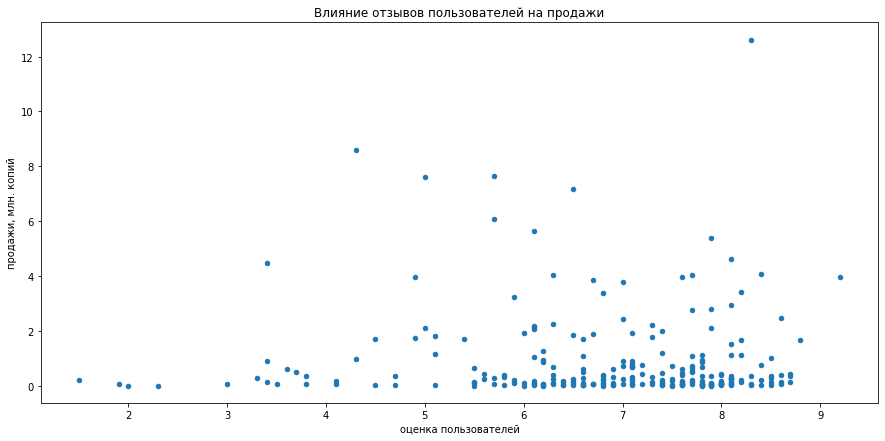

In [39]:
ps4_user_score.plot(x='user_score', y='total_sales', kind='scatter', figsize=(15,7)) #добавила диаграмму рассеяния
plt.title('Влияние отзывов пользователей на продажи')
plt.xlabel('оценка пользователей')
plt.ylabel('продажи, млн. копий')
plt.show()

In [40]:
print('Коэффициент корреляции между оценками пользователей и продажами:', ps4_user_score['user_score'].corr(ps4_user_score['total_sales']))

Коэффициент корреляции между оценками пользователей и продажами: -0.040131589472697356


>Зависимости практически нет. Можно говорить о том, что оценки юзеров не влияют на продажи в мире игр. 

Посмотрим на коэффициент корреляции у других платформ из актуального периода

In [41]:
user_score_3ds = games_actual.query('platform == "3ds" and user_score > 0')
print('3ds:', user_score_3ds['user_score'].corr(user_score_3ds['total_sales']))
user_score_pc = games_actual.query('platform == "pc" and user_score > 0')
print('pc:', user_score_pc['user_score'].corr(user_score_pc['total_sales']))
user_score_ps3 = games_actual.query('platform == "ps3" and user_score > 0')
print('ps3:', user_score_ps3['user_score'].corr(user_score_ps3['total_sales']))
user_score_psp = games_actual.query('platform == "psp" and user_score > 0')
print('psp:', user_score_psp['user_score'].corr(user_score_psp['total_sales']))
user_score_psv = games_actual.query('platform == "psv" and user_score > 0')
print('psv:', user_score_psv['user_score'].corr(user_score_psv['total_sales']))
user_score_wii = games_actual.query('platform == "wii" and user_score > 0')
print('wii:', user_score_wii['user_score'].corr(user_score_wii['total_sales']))
user_score_wiiu = games_actual.query('platform == "wiiu" and user_score > 0')
print('wiiu:', user_score_wiiu['user_score'].corr(user_score_wiiu['total_sales']))
user_score_x360 = games_actual.query('platform == "x360" and user_score > 0')
print('x360:', user_score_x360['user_score'].corr(user_score_x360['total_sales']))
user_score_xone = games_actual.query('platform == "xone" and user_score > 0')
print('xone:', user_score_xone['critic_score'].corr(user_score_xone['total_sales']))

3ds: 0.2151932718527028
pc: -0.07159665703472451
ps3: -0.16676141347662118
psp: nan
psv: -0.16845504978064446
wii: 1.0
wiiu: 0.40792645792170773
x360: -0.138444570945665
xone: 0.42211185105557664


> Выводы подтверждаются. Более сильная корреляция у **wiiu** и **xone** (иногда, но не часто с высокой оценкой юзеров продажи растут), отрицательная корреляция у четырех платформ, включая и **ps4**. У **psp** нет оценок.  
Интересно посмотреть на сильную зависимость у **wiiu**. По этой платформе точно можно сказать, что чем выше оценка пользователя, тем выше продажи. Это интересно, т.к. мы помним, что ей удается сделать прекрасный показатель продаж малым количеством игр. 

### Распределение игр по жанрам. 

In [42]:
games_genre = games_actual.groupby('genre').agg({'name': 'count', 'total_sales': 'sum'}).reset_index().sort_values(by='total_sales', ascending=False)
games_genre.columns = ['genre', 'n_games', 'total_sales']
display(games_genre)

,genre,n_games,total_sales
0,action,619,199.36
8,shooter,128,170.94
10,sports,161,109.48
7,role-playing,221,101.44
3,misc,113,37.55
2,fighting,60,28.22
6,racing,69,27.52
4,platform,38,18.09
1,adventure,185,17.55
9,simulation,44,13.13


>4 самых прибыльных жанра:
>* action  
>* shooter  
>* sports  
>* role-playing  
>
>Интересно, что action продает всего на 14% больше, чем shooter, Хотя в shooter игр меньше практически в 5 раз. Интересно посмотреть на остальное соотношение

In [43]:
games_genre['ratio'] = games_genre['total_sales'] / games_genre['n_games']
display(games_genre)

,genre,n_games,total_sales,ratio
0,action,619,199.36,0.322068
8,shooter,128,170.94,1.335469
10,sports,161,109.48,0.680000
7,role-playing,221,101.44,0.459005
3,misc,113,37.55,0.332301
2,fighting,60,28.22,0.470333
6,racing,69,27.52,0.398841
4,platform,38,18.09,0.476053
1,adventure,185,17.55,0.094865
9,simulation,44,13.13,0.298409


>Shooter явно лидер. Надо обратить внимание на него в первую очередь, ведь тогда мы можем сделать больший объем продаж меньшими затратами(игр нужно будет продать меньше). Из лидеров также идут sports и role playing, выделяется fighting и platform, и уже потом идет action.  
>
>Самый низкий показатель у puzzle, а в соотношение продаж к количеству игр проигрывает adventure и strategy.

## Портрет пользователя каждого региона

### Популярные платформы (ТОП-5) для каждого региона. 

In [44]:
platform_na = games_actual.groupby('platform').agg({'na_sales': 'sum'}).reset_index().sort_values(by='na_sales', ascending=False)
platform_na.head()

,platform,na_sales
3,ps4,98.61
9,xone,81.27
8,x360,28.30
0,3ds,22.64
2,ps3,22.05


In [45]:
platform_eu = games_actual.groupby('platform').agg({'eu_sales': 'sum'}).reset_index().sort_values(by='eu_sales', ascending=False)
platform_eu.head()

,platform,eu_sales
3,ps4,130.04
9,xone,46.25
2,ps3,25.54
1,pc,17.97
0,3ds,16.12


In [46]:
platform_jp = games_actual.groupby('platform').agg({'jp_sales': 'sum'}).reset_index().sort_values(by='jp_sales', ascending=False)
platform_jp.head()

,platform,jp_sales
0,3ds,44.24
3,ps4,15.02
5,psv,14.54
2,ps3,11.22
7,wiiu,7.31


>В Европе и Северной Америке лидеры ps4 и xone. Четверка топов схожа с разнице в продажах, отличие в том, что в Европе в ТОП вырывается pc, а в америке x360.  
>
>В Японии ситуация другая. 3Ds в лидерах, хотя в других регионах он занимает последнее и предпоследнее место в топе-5. Продажи этой платформы превышают продажи Америки в 2 раза, а европейские еще больше. Эта платформа абсолютный лидер в Японии.  
>
>Ps4 продает в Японии меньше чем в 8 раз по сравнению с Европой. У ps4, psv и ps3 в Японии практически ровные показатели. В ТОПе появляется также wiiu. 

### Популярные жанры (топ-5) для каждого региона. Различия в долях продаж

In [47]:
genre_na = games_actual.groupby('genre').agg({'na_sales': 'sum'}).reset_index().sort_values(by='na_sales', ascending=False)
genre_na.head()

,genre,na_sales
8,shooter,79.02
0,action,72.53
10,sports,46.13
7,role-playing,33.47
3,misc,15.05


In [48]:
genre_eu = games_actual.groupby('genre').agg({'eu_sales': 'sum'}).reset_index().sort_values(by='eu_sales', ascending=False)
genre_eu.head()

,genre,eu_sales
0,action,74.68
8,shooter,65.52
10,sports,45.73
7,role-playing,28.17
6,racing,14.13


In [49]:
genre_jp = games_actual.groupby('genre').agg({'jp_sales': 'sum'}).reset_index().sort_values(by='jp_sales', ascending=False)
genre_jp.head()

,genre,jp_sales
7,role-playing,31.16
0,action,29.58
2,fighting,6.37
3,misc,5.61
8,shooter,4.87


>В Америке популярны жанры shooter и action, в Японии role playing и action, в Европе в лидеры выбивается action и shooter. Интересно, что ТОП популярности в Америке и Европе shooter довольно не сильно популярен в Японии, хотя все равно входит в топ. И наоборот, на предпоследнем месте в Америке и Европе role playing, а в Японии этот жанр на первом. В Японии можем увидеть интерес к жанру fighting, а в Европе к racing.

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Для задачи нужно выяснить, влияет ли на продажи наличие рейтинга или не влияет. Определим, когда рейтинг есть и когда его нет. Для этого присвоим 1 - если рейтинг есть, и 0 - если его нет

In [50]:
games_actual['id'] = games_actual['rating']
games_actual['id'] = games_actual.rating.notna().astype('int')
games_actual.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,id
31,call of duty: black ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63,0
42,grand theft auto v,ps4,2014,action,3.96,6.31,0.38,1.97,9.7,8.3,m,12.62,1
47,pokemon omega ruby/pokemon alpha sapphire,3ds,2014,role-playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68,0
77,fifa 16,ps4,2015,sports,1.12,6.12,0.06,1.28,8.2,4.3,e,8.58,1
87,star wars battlefront (2015),ps4,2015,shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98,0
92,call of duty: advanced warfare,ps4,2014,shooter,2.81,3.48,0.14,1.23,8.3,5.7,m,7.66,1
94,fifa 17,ps4,2016,sports,0.66,5.75,0.08,1.11,8.5,5.0,e,7.60,1
96,super smash bros. for wii u and 3ds,3ds,2014,fighting,3.27,1.37,2.43,0.48,NaN,NaN,NaN,7.55,0
99,call of duty: black ops 3,xone,2015,shooter,4.59,2.11,0.01,0.68,NaN,NaN,NaN,7.39,0
105,fallout 4,ps4,2015,role-playing,2.53,3.27,0.24,1.13,8.7,6.5,m,7.17,1


#### Влияние наличия рейтинга ESRB на продажи в отдельном регионе

In [51]:
rating_na = games_actual.groupby('id').agg({'na_sales': 'sum'}).reset_index() #Северная Америка
display(rating_na)

,id,na_sales
0,0,64.72
1,1,219.34


In [52]:
rating_eu = games_actual.groupby('id').agg({'eu_sales': 'sum'}).reset_index() #Европа
display(rating_eu)

,id,eu_sales
0,0,58.95
1,1,211.73


In [53]:
rating_jp = games_actual.groupby('id').agg({'jp_sales': 'sum'}).reset_index() #Япония
display(rating_jp)

,id,jp_sales
0,0,56.90
1,1,36.19


>В Европе и Америке платформы с наличием рейтинга имеют более высокие продажи, практически в 3,5 раза, чем когда его нет. В Японии ситуация другая, продажи практически ровные. В Японии влияния на продажи наличия рейтинга нет


### Популярные возрастные рейтинги в разных регионах

In [54]:
games_actual['rating'].unique() #изначально у нас были старые значения k-a равные e, проверим не попали ли они случайно к нам в выборку.

array([nan, 'm', 'e', 't', 'e10+'], dtype=object)

#### Северная Америка

In [55]:
games_actual['rating'] = games_actual['rating'].astype(str) 
age_rating_na = games_actual.groupby('rating').agg({'na_sales': 'sum'}).reset_index().sort_values(by='na_sales', ascending=False)
display(age_rating_na)

,rating,na_sales
2,m,96.42
3,nan,64.72
0,e,50.74
4,t,38.95
1,e10+,33.23


>В Северной Америке **в топ** выходит рейтинг **mature** для взрослых 17+ . Как сообщает Википедия, "проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории". 
>
>На **втором месте** по продажам - игры без рейтинга. Похоже, что, действительно в Америке рейтинг ESRB просто довольно частая вещь, и отношения к продажам она не имеет.  
>
>На втором месте, но почти в 2 раза менее популярным явлются игры с рейтингом **everyone** (от 6 лет, практически без насилия)  
 

#### Европа

In [56]:
age_rating_eu = games_actual.groupby('rating').agg({'eu_sales': 'sum'}).reset_index().sort_values(by='eu_sales', ascending=False)
display(age_rating_eu)

,rating,eu_sales
2,m,93.44
3,nan,58.95
0,e,58.06
4,t,34.07
1,e10+,26.16


>В Европе лидирующую позицию занимает также 17+. Популряные жанры также **shooter** и **action**, на втором месте **everyone**. Показатели кстати, приближенные к Америке. Отрывается от Северной Америки только 10+, но тоже не очень значительно. Видимо, в Европе "мягкие" игрушки любят чуть больше, или же просто больше детей в них играют

#### Япония

In [57]:
age_rating_jp = games_actual.groupby('rating').agg({'jp_sales': 'sum'}).reset_index().sort_values(by='jp_sales', ascending=False)
display(age_rating_jp)

,rating,jp_sales
3,nan,56.90
4,t,14.78
0,e,8.94
2,m,8.01
1,e10+,4.46


>В Японии ESRB вещь не очень популярная, топ продаж вообще без этого рейтинга. А самыми популярными яляются игры **teens**, 
его популярность в 2 раза превышает своих собратов на 2 и 3 месте. Вспомним, что топовым жанром оказался **role-playing**. По всей вероятности, японцы не только не склонны к насилию, но и взрослые не особенно покупают игры для себя

## Проверка гипотез

### Гипотеза №1 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза = средние пользовательские рейтинги платформ Xbox и PC одинаковые.  
Альтернативная гипотеза = средние пользовательские рейтинги платформ Xbox и PC разные

In [58]:
xbox_one_rating = games_actual.query('platform == "xone" and user_score > 0')['user_score']
pc_one_rating = games_actual.query('platform == "pc" and user_score > 0')['user_score']
#xbox_one_rating.describe()
#pc_one_rating.describe()

In [59]:
alpha = 0.05

results = st.ttest_ind(xbox_one_rating, pc_one_rating, equal_var = True)#выбираем параметр True, т.к.  стандартные отклоненяи выборок различаются не сильно
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


> Подтвердилось, что средние пользовательские рейтинги платформ Xbox и PC одинаковые

### Гипотеза №2 - Средние пользовательские рейтинги жанров Action и Sports разные

Нулевая гипотеза = средние пользовательские рейтинги жанров Action и Sports одинаковые. Альтернативная гипотеза = средние пользовательские рейтинги жанров Action и Sports разные

In [60]:
action_rating = games_actual.query('genre == "action" and user_score >0')['user_score']
sports_rating = games_actual.query('genre == "sports" and user_score >0')['user_score']
#action_rating.describe()
#sports_rating.describe()

In [61]:
alpha = 0.05

results = st.ttest_ind(action_rating, sports_rating, equal_var = True) 
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.8711147985105864e-19
Отвергаем нулевую гипотезу


> Cредние пользовательские рейтинги жанров Action и Sports разные

##  Результаты исследования

Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

1. Для прогнозирования успешных продуктов выбран период с 2014 по 2016 год, поскольку, как показало исследование, популярные игры, выпущенные в этих годах, станут наиболее популярными или вообще достигнут пика популярности именно в 2017 году. Поэтому период был взят, как наиболее актуальный.
2. **Платформы.** 3 платформы-лидера: **PS4, Xone, 3ds**. Стоит сделать упор на игры, выпущенные именно на этих платформах. PS4 является абсолютным лидером, однако это достигается засчет количества игр. На 4 месте находиться платформа wiiu. Она же в топ 5 по Японии. Она же при количестве игр, которое на 70% ниже Ps4, дает выручку всего на 5% меньше тоже самого ps4. Если мы хотим выходить на японский рынок, стоит задуматься о ней в первую очередь. Но если только у игры хорошие отзывы, как показало исследование, на этой платформе все четко - хорошая оценка пользователя приводит к увеличению продаж. 
3. **Оценки критиков и рейтинги.** Об оценках критиков и рейтингах беспокоиться особенно не стоит. Конечно, если они есть, то делать ставку на игры с низкими оценками не нужно. Но если оценка от 6 баллов (по 10 бальной шкале), стоит обратить внимание на такую игру и усилить рекламную кампанию. Игры без оценки также подойдут, если другие показатели говорят об их перспективности.
4.  **Рейтинг ESRB**. Продажи с рейтингом ESRB в Америке и Европе превышают продажи без рейтинга в 3,5 раза. В Японии результаты ровные, наличие рейтинга на продажи влиять не будет.
5. Если мы хотим выйти на рынок Америки и Европы, ставку надо сделать на Ps4 и Xone. В Японии на 3Ds, и я бы включила в японские кампании wiiu.
6. **Возраст и жанр.**  
* **Америка.** Исходя из рейтинга ERSB бОльшая доля американских геймеров - это 17+, а самый популярный жанр **shooter** (на втором месте **action**). Это 33% рынка. Однако 22% рынка - это игры без рейтинга вообще (то есть с неопредленной категорией возраста). Если разобраться с реальными возрастами в ней, возможно она увеличит менее популярные категории и добавит нам новых. Но вряд ли перебьет лидера. Поэтому я бы делала упор на эти 2 жанра и 17+ для Америки. Однако не стоит снимать со счетов **everyone**. Дети тоже хотят играть, а с ними и мамы, которым игрушка тоже может подойти
* **Европа.** Для Европы можно делать ставку на 17+, лидирует с сильным отрывом. Жанры те же, что и в Америке. Не забываем про everyone.  
* **Япония.** В Японии картина совершенно другая. Можно сделать акцент на **teens**, но тут также придется разобраться с возрастами другим способом. Игры с ESRB встречаются редко. Топовый жанр **role-playing**. Думаю, есть смысл сместить рекламный бюджет в сторону японских подростков.  

Также для Америки и Европы популярен жанр **Sports**. Я бы выбрала наиболее топовые игры и часть бюджета выделила бы и для них. Могут быть какие-то новые супер-популярные игрушки, которые будут хорошо продаваться. Этот жанр интересен для этих рынков. Вполне возможно, что тут будет кардинально другой портрет клиента. Но нужно проверять дополнительно
